In [1]:
import graph_tool.all as gt
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import h5py # management and storage of large datasets
import os
import scipy.sparse
from scipy.integrate import solve_ivp
from scipy.stats import poisson
import pandas as pd

## minimal example LV

In [34]:
"""
g = gt.collection.data["karate"].copy()
E = g.num_edges()
N = g.num_vertices() # undirected graph ->
# adjacency matrix is symmetric -> eigenvalues are real
#print(f"number of nodes= {N}, num edges= {E}")

s = g.new_vp("double", vals=  10+ 10 * np.random.random(g.num_vertices()))
r = g.new_vp("double", val= + 20) 
w = g.new_ep("double", vals=np.random.normal(0.5, 1.2, g.num_edges()))
for v in g.vertices():
    e = g.add_edge(v,v) #adds if not already present in adiacency matrix
    w[e] = - 2.5 #resets diagonal to -1

## Careful: these propertymaps have not been assigned to the graph yet
#g.vp["growth_rates"] = r
# Print all vertex properties
#print(g.vp)
#print(g.vp.growth_rates.a) #get the values in a numpy array

A = gt.adjacency(g, weight= w) #sparse
A_dense = A.toarray()

# Check linear stability
eigenvalues = np.linalg.eigvals(A_dense)
re_eigenvalues = np.real(eigenvalues)
lmax = max(re_eigenvalues)
print(f"leading eigenval = {lmax}")
"""

leading eigenval = -0.44593094388517274


Nan values: False


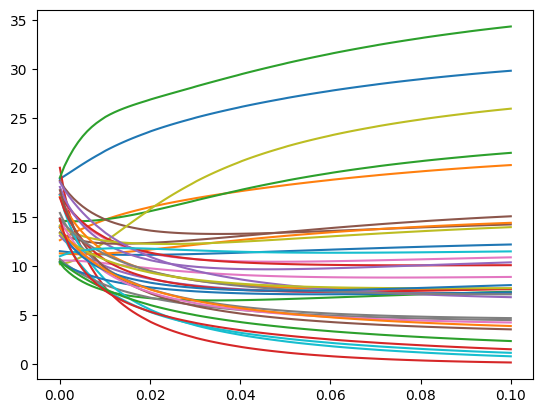

In [35]:
"""
sigma_ = 0.
ts = np.linspace(0, 0.1 , 100)
# Peixoto solution
state = gt.LVState(g, s=s, r=r, w=w, sigma= sigma_) #does not seem stochastic at all
ss = []
for t in ts:
    ## RK not suited for stochastic ODEs, use Euler instead
    ret = state.solve_euler(t, dt = 0.0001) #integrate up to time t
    ss.append(state.get_state().fa.copy())
# ss is a list of VertexPropertyMap objects
ss = np.array(ss).T 
has_nan = np.isnan(ss).any()
print(f"Nan values: {has_nan}")  
#print(f"nrows= {ss.shape[0]}, ncols= {ss.shape[1]}")
fig, ax = plt.subplots()
for v in g.vertices():
    ax.plot(ts, ss[int(v)])
"""

In [37]:
"""
state = gt.PseudoNormalBlockState(ss)
ret = state.mcmc_sweep(niter=10, verbose = False)
delta = abs(ret[0]) #entropy difference
print(f"delta = {delta}")
while delta > 0.01:
    ret = state.mcmc_sweep(niter=10, verbose = False)
    delta = abs(ret[0]) #entropy difference
    print(f"delta = {delta}")

u = state.get_graph()      # reconstructed network
print(f"True graph. Number of nodes {g.num_vertices()}, number of edges= {g.num_edges()}")
print(f"Reconstructed graph. Number of nodes {u.num_vertices()}, number of edges= {u.num_edges()}")
w_r = state.get_x()        # reconstructed weights
print(gt.similarity(g, u, w, w_r))

cnorm = mpl.colors.Normalize(vmin=-abs(w.fa).max(), vmax=abs(w.fa).max())
gt.graph_draw(g, g.vp.pos, edge_pen_width=gt.prop_to_size(w.t(abs), 2, 8, power=1), edge_color=w,
              ecmap=mpl.cm.coolwarm_r, ecnorm=cnorm)
gt.graph_draw(u, g.vp.pos, edge_pen_width=gt.prop_to_size(w_r.t(abs), 2, 8, power=1), edge_color=w_r,
              ecmap=mpl.cm.coolwarm_r, ecnorm=cnorm)
"""

delta = 6369.206207950997
delta = 3693.9373668957437
delta = 2015.1695054057923
delta = 385.50839377035777
delta = 106.0246091744904
delta = 23.99332182250856
delta = 9.754523458658934
delta = 21.66797907482513
delta = 19.080481926849934
delta = 2.9995539759022187
delta = 6.145226499419808
delta = 0.0007156727333228474
True graph. Number of nodes 34, number of edges= 112
Reconstructed graph. Number of nodes 34, number of edges= 59
0.0036800895183203477


## IsingGlauber example

In [46]:
g = gt.collection.data["dolphins"]
E = g.num_edges()
N = g.num_vertices()
print(f"num vertex= {N}")
w = g.new_ep("double",
              vals=np.random.normal(N/(2*E), .05, E)
              #vals=np.random.choice([-1, 0, +1])
              )
istate = gt.IsingGlauberState(g, w=w)

M = 1000 #number of samples
X = []
for m in range(M):
    istate.iterate_sync()
    X.append(istate.get_state().a.copy())
X = np.array(X).T 
print(f"nrows= {X.shape[0]}, ncols= {X.shape[1]}")

state = gt.IsingGlauberBlockState(X)
for i in range(10):
    delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
    print(delta)

u = state.get_graph()      # reconstructed network
w_r = state.get_x()        # reconstructed weights
t_r = state.get_theta()    # reconstructed thetas

print(gt.similarity(g, u, w, w_r))

num vertex= 62
nrows= 62, ncols= 1000
-4609.914067274933
-3373.9856314473764
-1026.3266166549506
-280.48996395593764
-17.601373540195738
-36.89470226351986
-6.750669225034311
-0.0046459477746054745
-1.2431482900865376e-06
-3.8559377912861237e-10
0.8877732774361035


Performance of reconstruction is HIGHLY dependent on parameters even for the simplest model which is probably the ising.
Here, with abs(weights)= 1/kmean= 0.3 the inference is accurate, while for abs(weights)= kmean= 3 algorithm fails. its only one order of magnitude apart.

If coupling is too strong (changes in the system are too abrupt) it wont work.

In [2]:
g = gt.collection.data["dolphins"]
E = g.num_edges()
N = g.num_vertices()
print(f"num vertex= {N}")
print(f"real num edges: {E}")
k_mean = sum(g.degree_property_map("total").a)/ g.num_vertices()
print(f"k mean: {k_mean}")
gt.graph_draw(g, output= "gt_performance_test/images/ising/dolphin.pdf")

num vertex= 62
real num edges: 159
k mean: 5.129032258064516


<VertexPropertyMap object with value type 'vector<double>', for Graph 0x17b0ca150, at 0x178cb8d40>

In [3]:
alphas = np.arange(0.1, 1.2, 0.2)
results = []
for i,alpha in enumerate(alphas):
    print(f"{i}/ {len(alphas)}")
    nodes = []
    edges = []
    w_jaccard = []
    uw_jaccard = []
    for _ in range(1):
        #Weight assignment
        w = g.new_edge_property("double",
                                vals=[alpha* (1/k_mean) for _ in range(E)]
                                #vals=np.random.normal(1/k_mean, 0.1, g.num_edges())
                                )
        g.ep["weights"] = w
        pos = gt.sfdp_layout(g= g, eweight=g.ep["weights"])
        # Dynamics
        istate = gt.IsingGlauberState(g, w=w, beta= 2)
        M = 1000
        X = []
        for m in range(M):
            istate.iterate_sync()
            X.append(istate.get_state().a.copy())
        X = np.array(X).T 
        if not np.isfinite(X).all():
            raise ValueError("Invalid values")
        # Reconstruction
        state = gt.IsingGlauberBlockState(X)
        delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
        print(delta)
        while np.abs(delta) > 0.01:
            delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
            print(delta)
        u = state.get_graph()      # reconstructed network
        w_r = state.get_x()        # reconstructed weights
        t_r = state.get_theta()    # reconstructed thetas
        nodes.append(u.num_vertices())
        edges.append(u.num_edges())
        w_jaccard.append(gt.similarity(g, u, w, w_r))
        uw_jaccard.append(gt.similarity(g, u))

    results.append({
        'alpha': alpha,
        'nodes': np.mean(nodes),
        'edges': np.mean(edges),
        "weighted_jaccard": np.mean(w_jaccard),
        "unweighted_jaccard": np.mean(uw_jaccard)
    })
result_df = pd.DataFrame(results)
result_df.to_csv("prova_ising_beta_2.csv")

0/ 6
-0.036237857640230686
0.0
1/ 6
-1033.2366647844583


KeyboardInterrupt: 

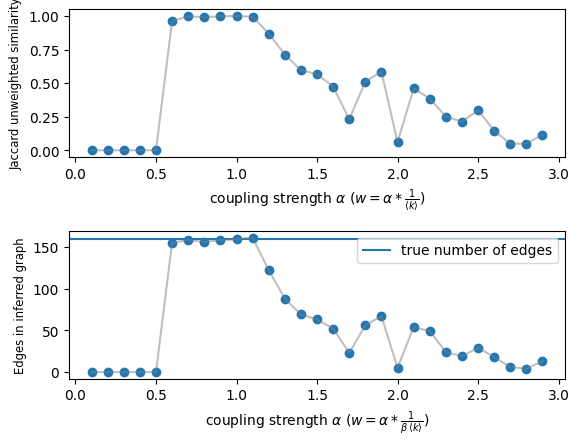

In [24]:
# Plot results
df = pd.read_csv("prova_ising.csv")
fig, (ax1, ax2) = plt.subplots(2,1)
plt.subplots_adjust(wspace = 0.5 , hspace= 0.5)


ax1.scatter(df['alpha'], df['unweighted_jaccard'], label=  "inferred graph")
ax1.plot(df['alpha'], df['unweighted_jaccard'], color = 'grey', alpha = 0.5)
ax1.set_xlabel(r"coupling strength $\alpha$ ($w = \alpha * \frac{1}{\langle k \rangle}$)")
ax1.set_ylabel("Jaccard unweighted similarity", fontsize= 'small')

ax2.axhline(y = E, label= "true number of edges")
ax2.scatter(df['alpha'], df['edges'])
ax2.plot(df['alpha'], df['edges'], color = 'grey', alpha = 0.5)
ax2.set_xlabel(r"coupling strength $\alpha$ ($w = \alpha * \frac{1}{\beta\,\langle k \rangle}$)")
ax2.set_ylabel("Edges in inferred graph", fontsize= 'small')
plt.legend()

os.makedirs("gt_performance_test/images/ising", exist_ok=True)
plt.savefig("gt_performance_test/images/ising/coupling.pdf")

## Same graph, varying number of samples

In [8]:
g = gt.collection.data["dolphins"]
E = g.num_edges()
N = g.num_vertices()
print(f"num vertex= {N}")
print(f"real num edges: {E}")
k_mean = sum(g.degree_property_map("total").a)/ g.num_vertices()
print(f"k mean: {k_mean}")
w = g.new_edge_property("double",
                        vals=[1/k_mean for _ in range(E)]
                        )
g.ep["weights"] = w

num vertex= 62
real num edges: 159
k mean: 5.129032258064516


In [9]:
M_val = [2** n for n in np.arange(4, 11, 1)]
results_eq = []
results_non_eq = []

for z in range(3):
    print(f"repetition {z}")
    # Dynamics
    istate = gt.IsingGlauberState(g, w=w)
    X_tot = []
    for m in range(2**10):
        istate.iterate_sync()
        X_tot.append(istate.get_state().a.copy())
    X_tot = np.array(X_tot).T 
    if not np.isfinite(X_tot).all():
        raise ValueError("Invalid values")
    
    # Reconstruction at equilibrium
    for i,M in enumerate(M_val):
        print(f"{i}/ {len(M_val)}")
        X = X_tot[:, np.max((X_tot.shape[1] - M), 0):] # I take the LAST samples, when system is equilibrated
        #X = X_tot[:, 0: min(X_tot.shape[1], M)] #not equilibrated
        state = gt.IsingGlauberBlockState(X)
        delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
        print(delta)
        while np.abs(delta) > 0.01:
            delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
            print(delta)
        u = state.get_graph()      # reconstructed network
        w_r = state.get_x()        # reconstructed weights
        t_r = state.get_theta()    # reconstructed thetas

        results_eq.append({
            'samples': M,
            'nodes': u.num_vertices(),
            'edges': u.num_edges(),
            "weighted_jaccard": gt.similarity(g, u, w, w_r),
            "unweighted_jaccard": gt.similarity(g, u)
        })
    
    # Reconstruction at NON equilibrium
    for i,M in enumerate(M_val):
        print(f"{i}/ {len(M_val)}")
        #X = X_tot[:, np.max((X_tot.shape[1] - M), 0):] # I take the LAST samples, when system is equilibrated
        X = X_tot[:, 0: min(X_tot.shape[1], M)] #not equilibrated
        state = gt.IsingGlauberBlockState(X)
        delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
        print(delta)
        while np.abs(delta) > 0.01:
            delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
            print(delta)
        u = state.get_graph()      # reconstructed network
        w_r = state.get_x()        # reconstructed weights
        t_r = state.get_theta()    # reconstructed thetas

        results_non_eq.append({
            'samples': M,
            'nodes': u.num_vertices(),
            'edges': u.num_edges(),
            "weighted_jaccard": gt.similarity(g, u, w, w_r),
            "unweighted_jaccard": gt.similarity(g, u)
        })


result_eq_df = pd.DataFrame(results_eq)
result_non_eq_df = pd.DataFrame(results_non_eq)

file_path_eq = "gt_performance_test/images/ising/dolphins_samples_eq.csv"
file_path_non_eq = "gt_performance_test/images/ising/dolphins_samples_non_eq.csv"

file_exists = os.path.exists(file_path_eq)
with open(file_path_eq, mode='a', newline='') as f:
    result_eq_df.to_csv(f, index=True, header= not file_exists)

file_exists = os.path.exists(file_path_non_eq)
with open(file_path_non_eq, mode='a', newline='') as f:
    result_non_eq_df.to_csv(f, index=True, header= not file_exists)

repetition 0
0/ 7
-116.24109337833589
-3.082572378869637
0.0
1/ 7
-190.9088548314474
0.0
2/ 7
-176.1047660682423
0.0
3/ 7
-453.92223839988344
-117.42253186706938
-30.41091311339019
-9.247435573815107
-0.63133129247786
-0.0016168549059898396
4/ 7
-1150.0683325511689
-618.3220555388381
-169.90352608448518
-34.69033047931434
-18.826877736830973
-2.2876633207448025
-2.709982644652362
-0.0033572933260614946
5/ 7
-2216.2501459537502
-1558.0070650896703
-456.97049284031857
-118.97945417776681
-53.76534170929778
-0.03851346856026794
-8.458124653998311e-07
6/ 7
-4303.844972587325
-3443.721028449159
-1214.550380035318
-167.7493623264053
-38.97028255676002
-0.0005404601188274682
0/ 7
-26.998308212560502
0.0
1/ 7
-60.167721427527916
-0.4688132678087875
0.0
2/ 7
-228.9152913762557
0.0
3/ 7
-510.4160452459007
-0.9550940973127808
0.0
4/ 7
-1495.9600395050843
-116.94750575748215
-72.25695464916626
-40.478715911119956
-24.860396905374127
-18.36802211673558
-8.354419619872099
-8.321862602431255
-3.98624

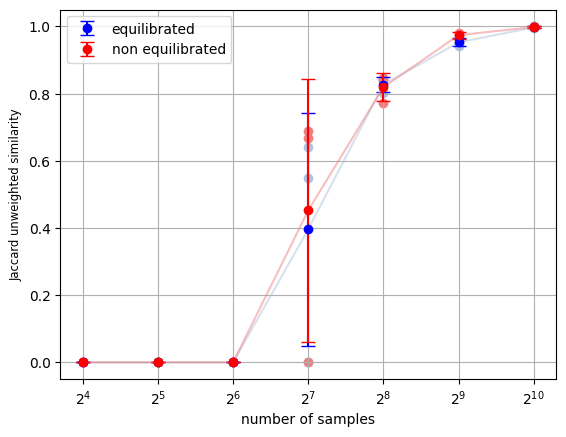

In [18]:
fig, ax = plt.subplots()

df = pd.read_csv("gt_performance_test/images/ising/dolphins_samples_eq.csv").sort_values(by='samples', ascending=False)
grouped_data = df.groupby('samples')['unweighted_jaccard'].agg(['mean', 'std'])

ax.scatter(df['samples'], df['unweighted_jaccard'], color= 'lightsteelblue')
ax.errorbar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], fmt='o', capsize=5, color= 'blue', label= "equilibrated")
ax.plot(grouped_data.index, grouped_data['mean'], color = 'lightsteelblue', alpha = 0.5)

df = pd.read_csv("gt_performance_test/images/ising/dolphins_samples_non_eq.csv").sort_values(by='samples', ascending=False)
grouped_data = df.groupby('samples')['unweighted_jaccard'].agg(['mean', 'std'])

ax.scatter(df['samples'], df['unweighted_jaccard'], color= 'lightcoral')
ax.errorbar(grouped_data.index, grouped_data['mean'], yerr=grouped_data['std'], fmt='o', capsize=5, color= 'red',  label = "non equilibrated")
ax.plot(grouped_data.index, grouped_data['mean'], color = 'lightcoral', alpha = 0.5)


ax.set_xscale('log', base = 2)
ax.set_xlabel("number of samples")
ax.set_ylabel("Jaccard unweighted similarity", fontsize= 'small')
ax.grid()

plt.legend()
os.makedirs("gt_performance_test/images/ising", exist_ok=True)
plt.savefig("gt_performance_test/images/ising/sampling_eq.pdf")

## Preliminary try with SBM

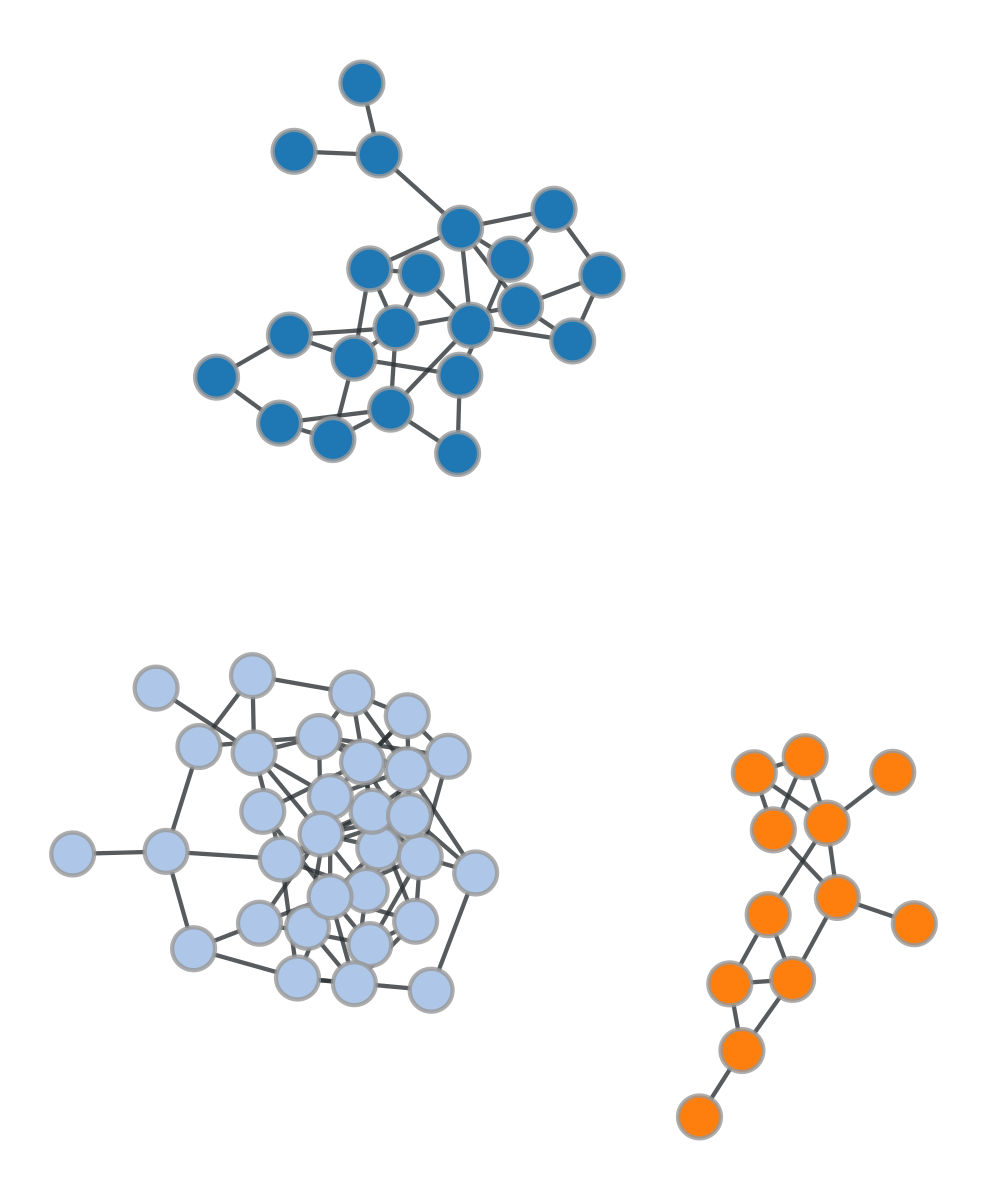

k mean: 4.15625


In [2]:
# SBM
def prob(a, b):
   if a == b:
       return 0.999
   else:
       return 0.001

def poisson_(mu = 5):
    return poisson.rvs(mu)
   
def sample_sbm(size: int, k: int = 4) -> gt.Graph:
    partitions = np.floor(np.float_power(size, 1/3))
    g, bm = gt.random_graph(size,
                            lambda: poisson_(k),
                            directed=False,
                            model="blockmodel",
                            block_membership=lambda: np.random.randint(partitions),
                            edge_probs=prob)
    return g,bm


g,bm = sample_sbm(size = 64)
gt.graph_draw(g, vertex_fill_color = bm)
k_mean = sum(g.degree_property_map("total").a)/ g.num_vertices()
print(f"k mean: {k_mean}")

In [3]:
M = 2000 #number of samples

w = g.new_ep("double", vals= [1/k_mean])
istate = gt.IsingGlauberState(g, w=w)

X = []
for m in range(M):
    istate.iterate_sync()
    X.append(istate.get_state().a.copy())
X = np.array(X).T 
print(f"nrows= {X.shape[0]}, ncols= {X.shape[1]}")

state = gt.IsingGlauberBlockState(X)
delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
i = 0
while np.abs(delta) > 0.001 and i < 15:
    i += 1
    delta, *_ = state.mcmc_sweep(niter=10, verbose=False)
    print(delta)

u = state.get_graph()      # reconstructed network
w_r = state.get_x()        # reconstructed weights
t_r = state.get_theta()    # reconstructed thetas

print(gt.similarity(g, u, w, w_r))

[0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015 0.2406015
 0.240

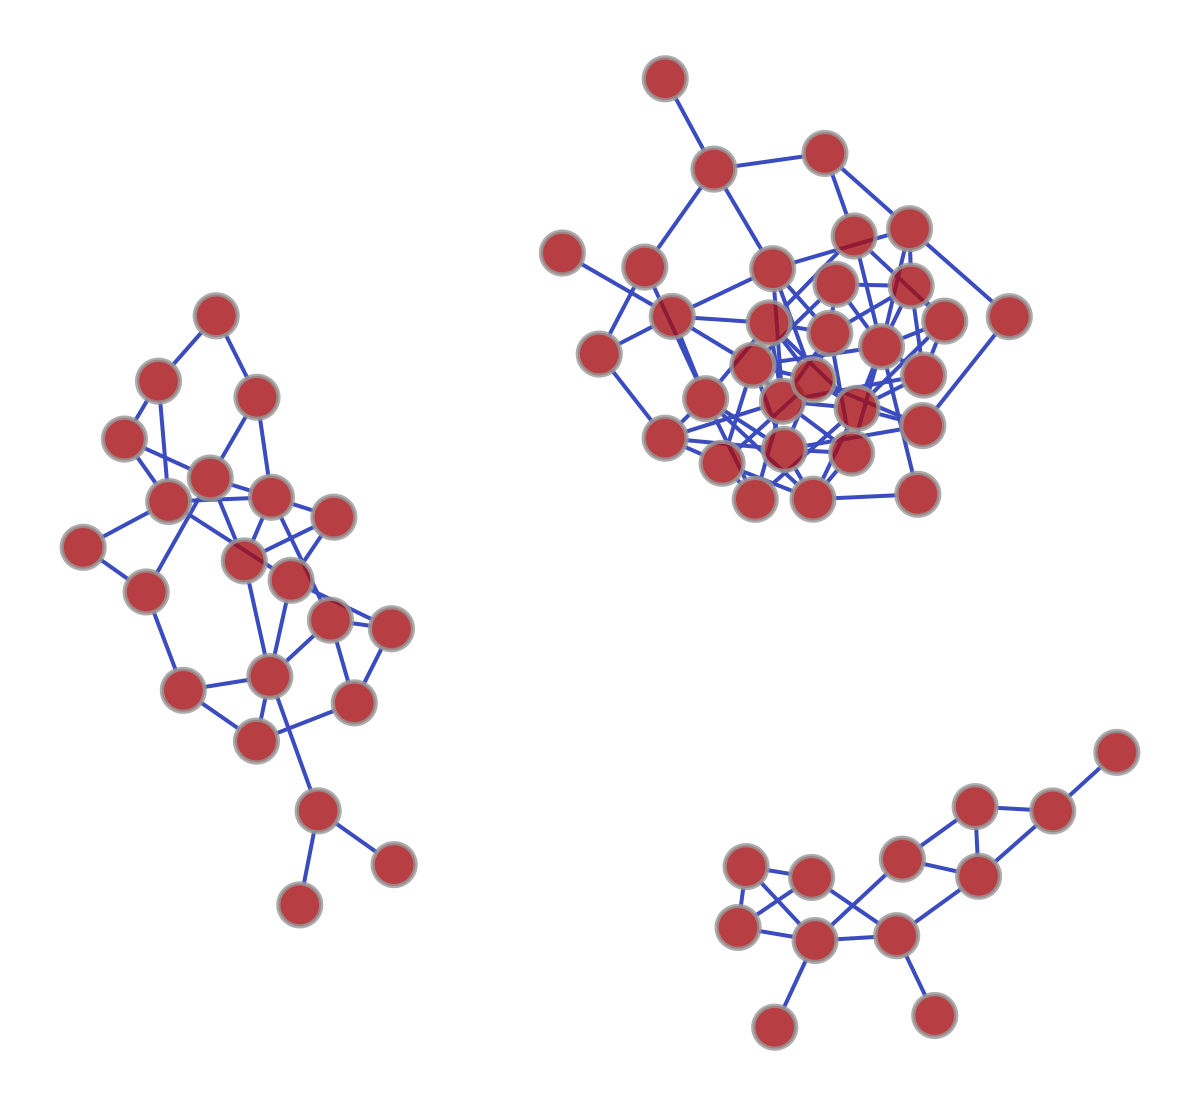

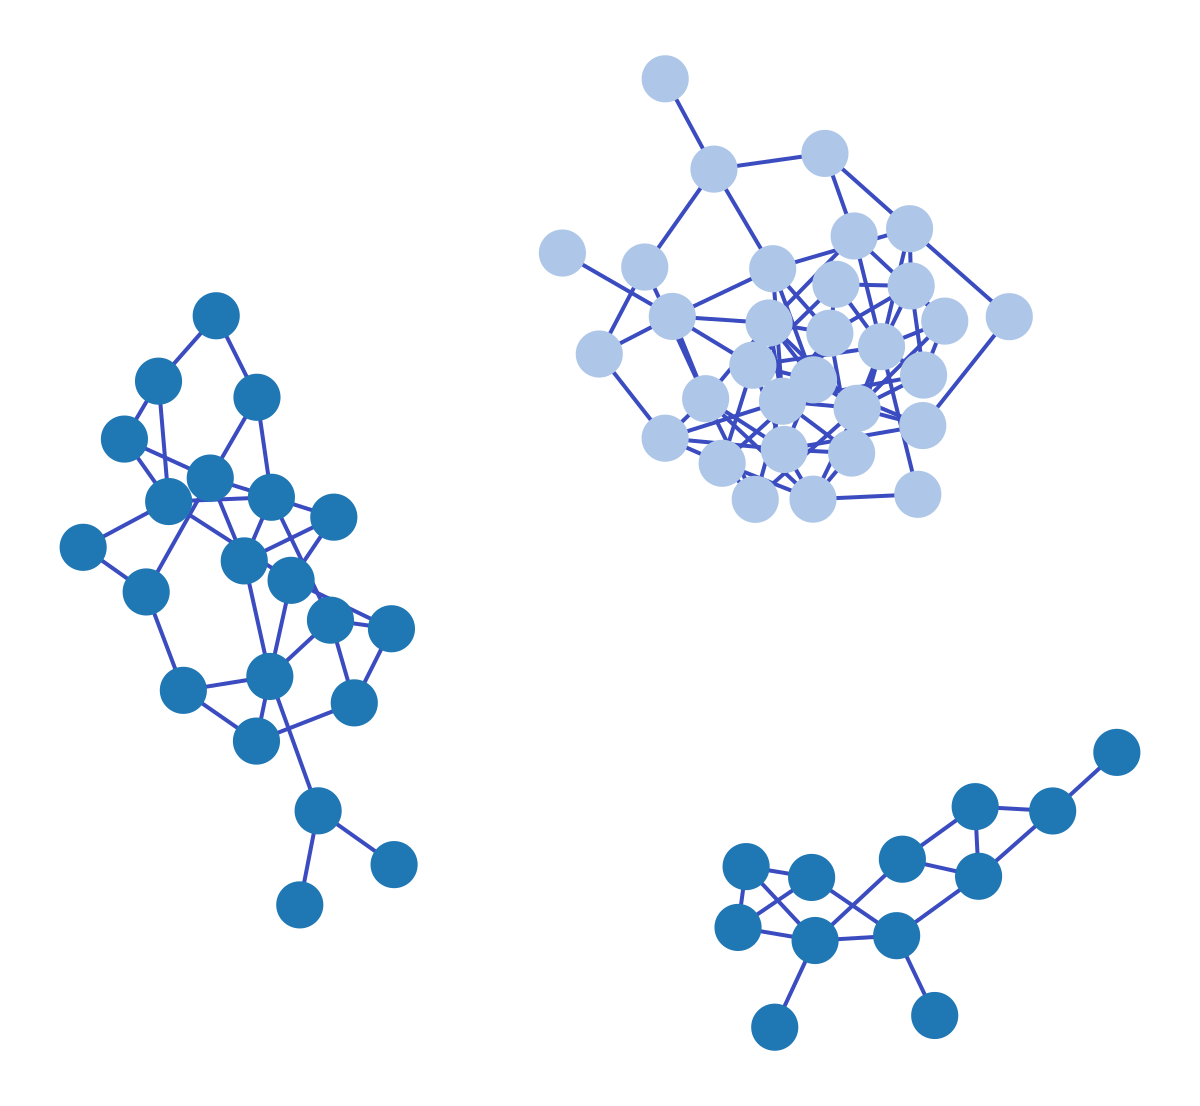

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x111128ce0, at 0x1666601a0>

In [4]:
g.vp['pos'] = gt.sfdp_layout(g)

cnorm = mpl.colors.Normalize(vmin=-abs(w.fa).max(), vmax=abs(w.fa).max())
# Original graph
gt.graph_draw(g, g.vp.pos, edge_pen_width=gt.prop_to_size(w.t(abs), 2, 8, power=1), edge_color=w,
              ecmap=mpl.cm.coolwarm_r, ecnorm=cnorm)
# Inferred graph with SBM partition
state.bstate.draw(pos=g.vp.pos, edge_gradient=[],
                  edge_pen_width=gt.prop_to_size(w_r.t(abs), 2, 8, power=1),
                  edge_color=w_r, ecmap=mpl.cm.coolwarm_r, ecnorm=cnorm)

## Simpler LV systems

(3, 10000)


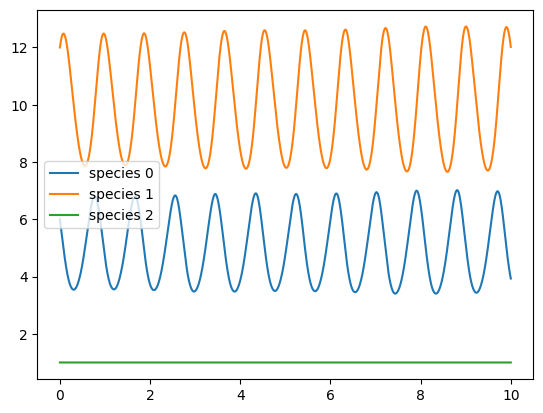

In [2]:
# three species system with two species prey-predator
alpha = 1.
W = alpha * np.array([
            [0, +1, 0], #W[i,j] is interaction of i ON j
            [-1, 0, 0],
            [0, 0, 0]])
g = gt.Graph(scipy.sparse.lil_matrix(W), directed=True)

r = g.new_vertex_property("double")
g.vp['growth_rates'] = r
r[0] = 10 #prey
r[1] = -5 #predator
r[2] = 0
#print(g.vp.growth_rates.a)

s = g.new_vertex_property("double")
g.vp['initial_state'] = s
s[0] = 6 # prey
s[1] = 12 #predator
s[2] = 1

"""
ts = np.linspace(0, 1 , 100)
state = gt.LVState(g, s = g.vp.initial_state, r=g.vp.growth_rates, w=g.ep.weight, sigma= 0.) 
ss = []
current_state = g.vp.initial_state.a
for t in ts:
    ## RK not suited for stochastic ODEs, use Euler instead
    ret = state.solve(t, y0= current_state) #integrate up to time t
    current_state = state.get_state().fa.copy()
    if np.isnan(current_state).any():
        break
    else:
        ss.append(current_state)
ss = np.array(ss).T  #now rows= species, columns= samples
ts = ts[0: ss.shape[1]]
fig, ax = plt.subplots()
for v in g.vertices():
    ax.plot(ts, ss[int(v)], label= f"species {v}")
plt.legend()
"""

def LV(t, s, W = W.T, r = r.a, noise = 0.):
    num_species = len(s)
    dsdt = np.zeros(num_species)
    for i in range(num_species):
        if s[i] <= (0.001):
            s[i] = 0
        dsdt[i] = s[i] * ((r[i] + (W @ s)[i])) + np.sqrt(s[i]) * np.random.normal(0, 1) * noise
    return dsdt

t_span = [0, 10.]
sol = solve_ivp(fun=LV, t_span=t_span, t_eval= np.linspace(t_span[0], t_span[1], 10000), y0= s.a)
print(sol.y.shape)

fig, ax = plt.subplots()
for i,v in enumerate(g.vertices()):
    ax.plot(sol.t, sol.y[i, :], label= f"species {i}")
plt.legend()

ss = sol.y

In [53]:
state = gt.LVBlockState(ss)
ret = state.mcmc_sweep(niter=1, verbose = False)
delta = abs(ret[0]) #entropy difference
print(f"delta = {delta}")
iter = 0
while delta > 0.01 and iter<10:
    iter+=1
    ret = state.mcmc_sweep(niter=1, verbose = False)
    delta = abs(ret[0]) #entropy difference
    print(f"delta = {delta}")

u = state.get_graph()      # reconstructed network
print(f"True graph. Number of nodes {g.num_vertices()}, number of edges= {g.num_edges()}")
print(f"Reconstructed graph. Number of nodes {u.num_vertices()}, number of edges= {u.num_edges()}")
w_r = state.get_x()        # reconstructed weights
"""
print(gt.similarity(g, u, w, w_r))

cnorm = mpl.colors.Normalize(vmin=-abs(w.fa).max(), vmax=abs(w.fa).max())
gt.graph_draw(g, g.vp.pos, edge_pen_width=gt.prop_to_size(w.t(abs), 2, 8, power=1), edge_color=w,
              ecmap=mpl.cm.coolwarm_r, ecnorm=cnorm)
gt.graph_draw(u, g.vp.pos, edge_pen_width=gt.prop_to_size(w_r.t(abs), 2, 8, power=1), edge_color=w_r,
              ecmap=mpl.cm.coolwarm_r, ecnorm=cnorm)
"""

delta = 9.54297165178808e-06
True graph. Number of nodes 3, number of edges= 2
Reconstructed graph. Number of nodes 3, number of edges= 0


'\nprint(gt.similarity(g, u, w, w_r))\n\ncnorm = mpl.colors.Normalize(vmin=-abs(w.fa).max(), vmax=abs(w.fa).max())\ngt.graph_draw(g, g.vp.pos, edge_pen_width=gt.prop_to_size(w.t(abs), 2, 8, power=1), edge_color=w,\n              ecmap=mpl.cm.coolwarm_r, ecnorm=cnorm)\ngt.graph_draw(u, g.vp.pos, edge_pen_width=gt.prop_to_size(w_r.t(abs), 2, 8, power=1), edge_color=w_r,\n              ecmap=mpl.cm.coolwarm_r, ecnorm=cnorm)\n'

[14.5 14.   0. ]
(3, 10000)


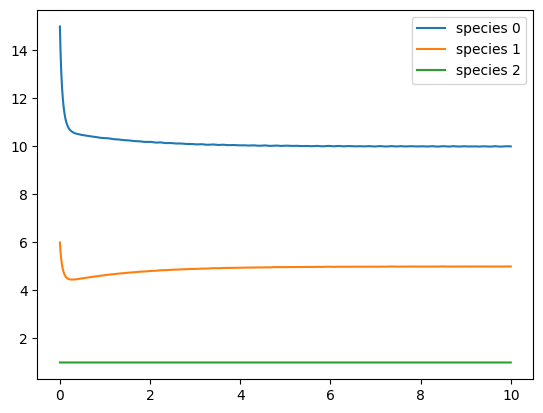

In [21]:
W =  np.array([
            [-1, -0.9, 0], #W[i,j] is interaction of i ON j
            [-0.9, -1, 0],
            [0, 0, 0]])
g = gt.Graph(scipy.sparse.lil_matrix(W), directed=True)

x_eq = np.array([10, 5, 1])

r_vec = - W @ x_eq
r = g.new_vertex_property("double")
g.vp['growth_rates'] = r
r[0] = r_vec[0]
r[1] = r_vec[1]
r[2] = r_vec[2]
print(g.vp.growth_rates.a)

s = g.new_vertex_property("double")
g.vp['initial_state'] = s
s[0] = 15
s[1] = 6
s[2] = 1



def LV(t, s, W = W.T, r = r.a, noise = 0.):
    num_species = len(s)
    dsdt = np.zeros(num_species)
    for i in range(num_species):
        if s[i] <= (0.001):
            s[i] = 0
        dsdt[i] = s[i] * ((r[i] + (W @ s)[i])) + np.sqrt(s[i]) * np.random.normal(0, 1) * noise
    return dsdt

t_span = [0, 10.]
sol = solve_ivp(fun=LV, t_span=t_span, t_eval= np.linspace(t_span[0], t_span[1], 10000), y0= s.a)
print(sol.y.shape)

fig, ax = plt.subplots()
for i,v in enumerate(g.vertices()):
    ax.plot(sol.t, sol.y[i, :], label= f"species {i}")
plt.legend()

ss = sol.y

In [22]:
state = gt.LVBlockState(ss)
ret = state.mcmc_sweep(niter=1, verbose = False)
delta = abs(ret[0]) #entropy difference
print(f"delta = {delta}")
iter = 0
while delta > 0.01 and iter<10:
    iter+=1
    ret = state.mcmc_sweep(niter=1, verbose = False)
    delta = abs(ret[0]) #entropy difference
    print(f"delta = {delta}")

u = state.get_graph()      # reconstructed network
print(f"True graph. Number of nodes {g.num_vertices()}, number of edges= {g.num_edges()}")
print(f"Reconstructed graph. Number of nodes {u.num_vertices()}, number of edges= {u.num_edges()}")
w_r = state.get_x()        # reconstructed weights

delta = 7.784680957401147e-05
True graph. Number of nodes 3, number of edges= 4
Reconstructed graph. Number of nodes 3, number of edges= 0
